In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.applications import VGG19, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

**2 class**

In [ ]:
# Load the data
label_data_path = '/kaggle/input/sr-label/data_lable.xlsx'
audio_folder_path = '/kaggle/input/speech-recognition-dataset/dataset/'

In [ ]:
# Read labels
labels_df = pd.read_excel(label_data_path)

In [ ]:
# Function to plot audio waveform
def plot_waveform(data, sr, title='Audio Waveform'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


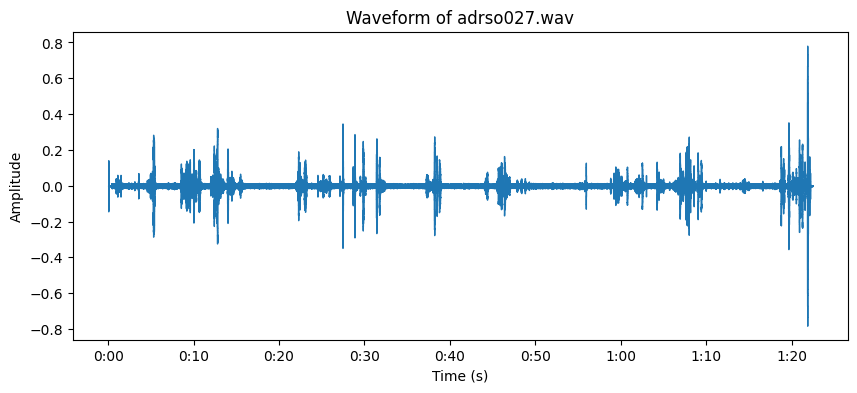

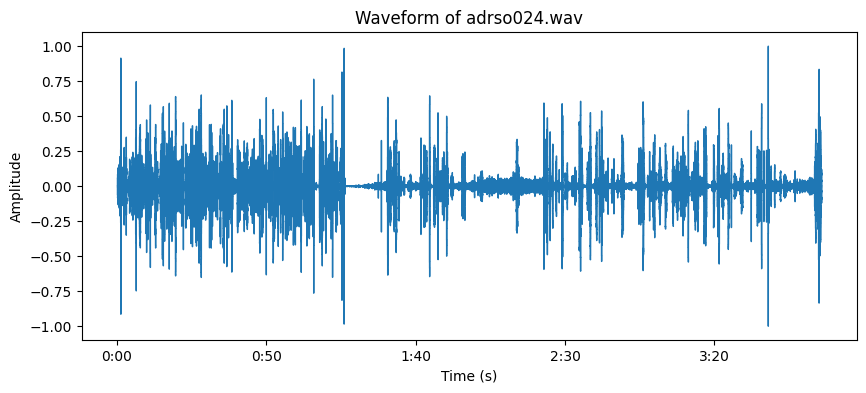

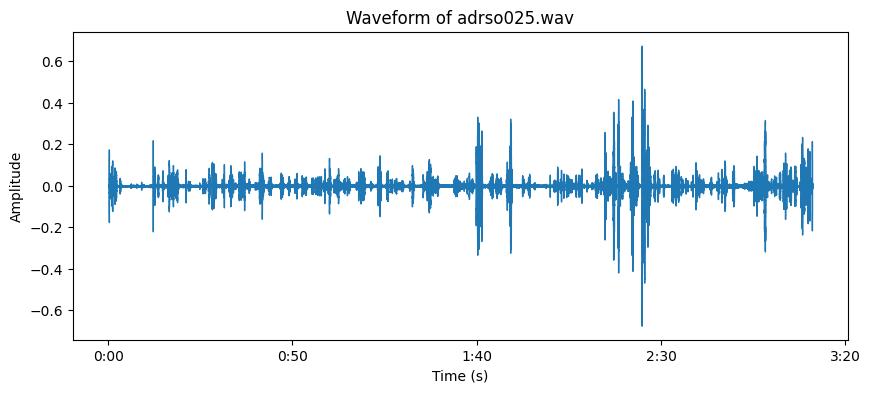

In [ ]:
# Load and plot initial audio files
for idx, row in labels_df.head(3).iterrows():  # Plot first 3 audio files
    file_path = os.path.join(audio_folder_path, row['ID'])
    data, sr = librosa.load(file_path, sr=None)
    plot_waveform(data, sr, title=f'Waveform of {row["ID"]}')

In [ ]:
# Data Augmentation Functions
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def pitch_shift(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

In [ ]:
# Load and augment the audio data
audio_data = []
audio_labels = []

def load_and_augment_audio(file_path, label):
    data, sr = librosa.load(file_path, sr=None)
    augmented_data = [
        data,
        add_noise(data),
        pitch_shift(data, sr),
        time_stretch(data, 0.9),
        time_stretch(data, 1.1)
    ]
    for aug_data in augmented_data:
        audio_data.append(aug_data)
        audio_labels.append(label)

In [ ]:
# Iterate through all files and apply augmentation
for idx, row in labels_df.iterrows():
    file_path = os.path.join(audio_folder_path, row['ID'])
    label = row['ad/cn']
    load_and_augment_audio(file_path, label)

In [ ]:
# Segment the audio data into 25-second segments
def segment_audio(data, sr, segment_length=25):
    segment_samples = sr * segment_length
    segments = []
    for start in range(0, len(data), segment_samples):
        end = start + segment_samples
        if end <= len(data):
            segments.append(data[start:end])
    return segments

In [ ]:
segmented_data = []
segmented_labels = []

In [ ]:
for data, label in zip(audio_data, audio_labels):
    sr = librosa.get_samplerate(audio_folder_path + labels_df['ID'][0])
    segments = segment_audio(data, sr)
    segmented_data.extend(segments)
    segmented_labels.extend([label] * len(segments))

In [ ]:
# Function to calculate percentage of silence
def calculate_silence_percentage(segment, sr, silence_threshold=0.01):
    silent_samples = np.sum(np.abs(segment) < silence_threshold)
    silence_percentage = silent_samples / len(segment)
    return silence_percentage

In [ ]:
# Feature extraction
def extract_features(data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

In [ ]:
features = []
silence_percentages = []

In [ ]:
for segment in segmented_data:
    sr = librosa.get_samplerate(audio_folder_path + labels_df['ID'][0])
    mfccs = extract_features(segment, sr)
    silence_percentage = calculate_silence_percentage(segment, sr)
    combined_features = np.append(mfccs, silence_percentage)
    features.append(combined_features)


In [ ]:
X = np.array(features)
y = np.array(segmented_labels)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Plot some X_train features with labels
def plot_features(X, y, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].reshape(-1, 1), aspect='auto', cmap='viridis')
        plt.title(f'Label: {y[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

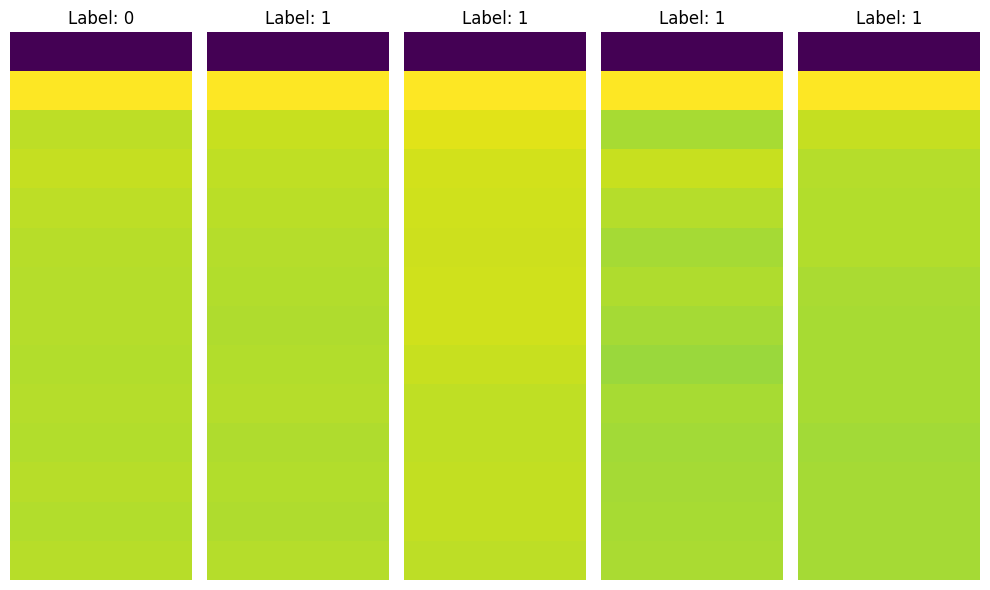

In [ ]:
# Plot first 5 training samples
plot_features(X_train, y_train)

In [ ]:
# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Building CNN model with regularization and additional dropout
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.002)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.002)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train CNN Model
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=150, batch_size=32, validation_split=0.2) #, callbacks=[early_stopping])

Epoch 1/150
19/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5195 - loss: 4.7505 

I0000 00:00:1719901147.288964     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.5302 - loss: 4.1802 - val_accuracy: 0.5679 - val_loss: 2.1996
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5387 - loss: 2.4070 - val_accuracy: 0.5833 - val_loss: 1.8743
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5776 - loss: 1.9238 - val_accuracy: 0.6235 - val_loss: 1.6823
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5885 - loss: 1.7147 - val_accuracy: 0.6235 - val_loss: 1.5516
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 1.5450 - val_accuracy: 0.5926 - val_loss: 1.4454
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 1.4407 - val_accuracy: 0.6698 - val_loss: 1.3591
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6297 - loss: 1.3373 - val_accuracy: 0.6389 - val_loss: 1.2783
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6301 - loss: 1.2735 - val_accuracy: 0.6451 - val_loss: 

In [ ]:
# Evaluate the models
cnn_scores = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'CNN Test Accuracy: {cnn_scores[1]}')

CNN Test Accuracy: 0.800000011920929


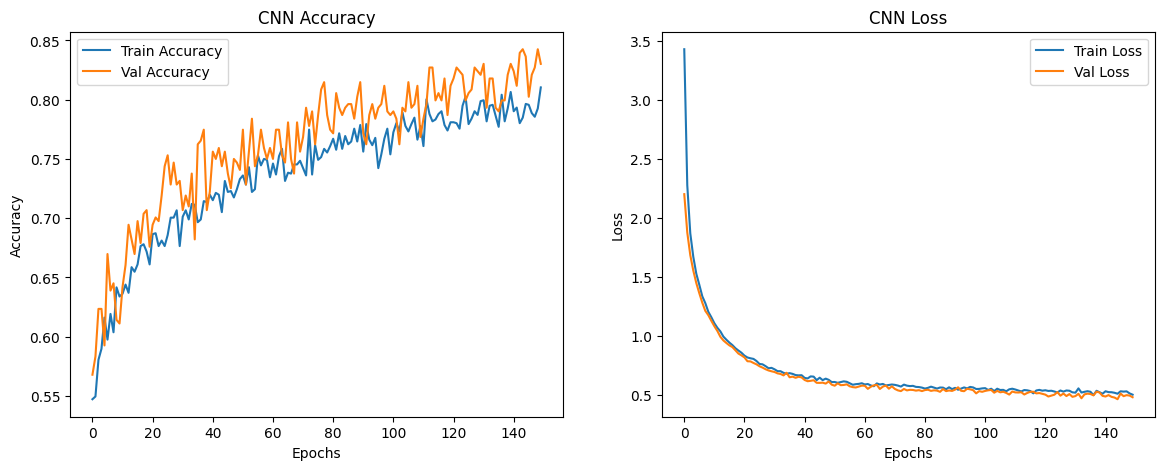

In [ ]:
# Plot LSTM training history
plot_training_history(history_cnn, 'CNN')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


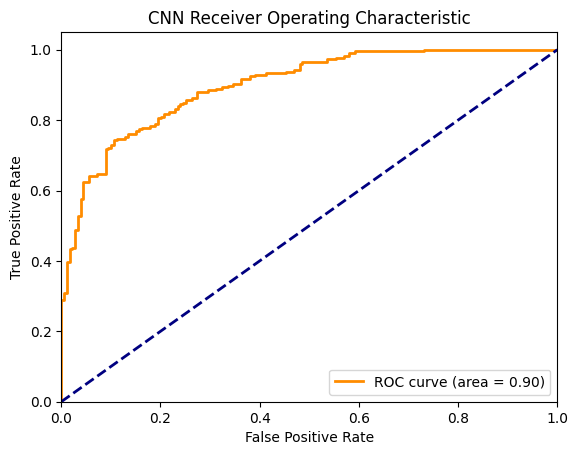

In [ ]:
# Plot LSTM ROC curve
y_pred_cnn = cnn_model.predict(X_test_cnn).ravel()
plot_roc_curve(y_test, y_pred_cnn, 'CNN')


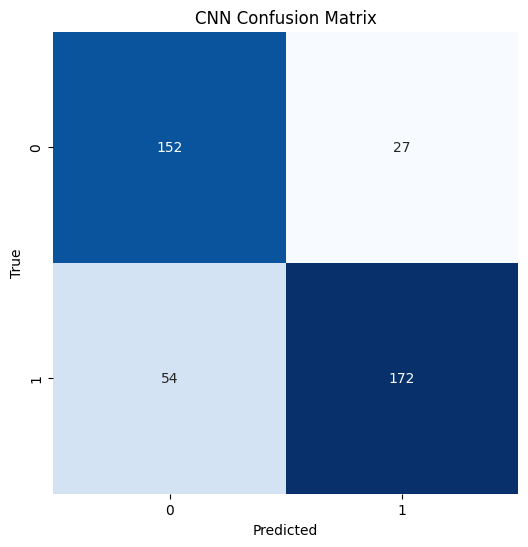

In [ ]:
# Plot LSTM confusion matrix
y_pred_cnn_class = (y_pred_cnn > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_cnn_class, 'CNN')


In [ ]:
# Print LSTM classification report
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_class))

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       179
           1       0.86      0.76      0.81       226

    accuracy                           0.80       405
   macro avg       0.80      0.81      0.80       405
weighted avg       0.81      0.80      0.80       405



In [ ]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(50, kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train LSTM Model
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_split=0.2)


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5686 - loss: 1.5048 - val_accuracy: 0.5679 - val_loss: 1.2889
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5634 - loss: 1.2917 - val_accuracy: 0.5401 - val_loss: 1.1404
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5910 - loss: 1.1134 - val_accuracy: 0.5401 - val_loss: 1.0333
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6226 - loss: 1.0053 - val_accuracy: 0.5648 - val_loss: 0.9640
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5998 - loss: 0.9704 - val_accuracy: 0.6080 - val_loss: 0.8929
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5974 - loss: 0.9069 - val_accuracy: 0.5864 - val_loss: 0.8626
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6059 - loss: 0.8604 - val_accuracy: 0.6204 - val_loss: 0.8165
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6254 - loss: 0.8279 - val_accuracy: 0.6420 - 

In [ ]:
# Evaluate the models
lstm_scores = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f'LSTM Test Accuracy: {lstm_scores[1]}')

LSTM Test Accuracy: 0.819753110408783


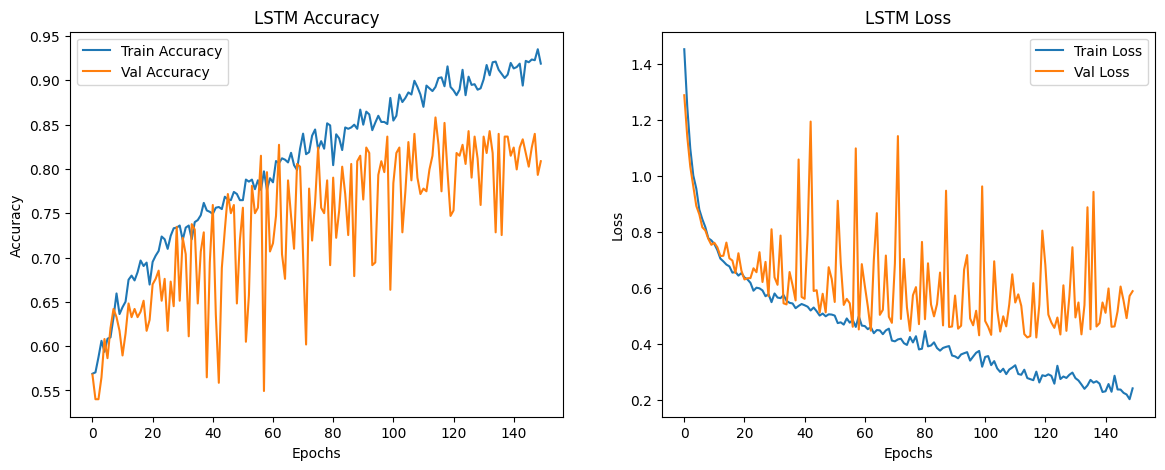

In [ ]:
# Plot LSTM training history
plot_training_history(lstm_history, 'LSTM')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


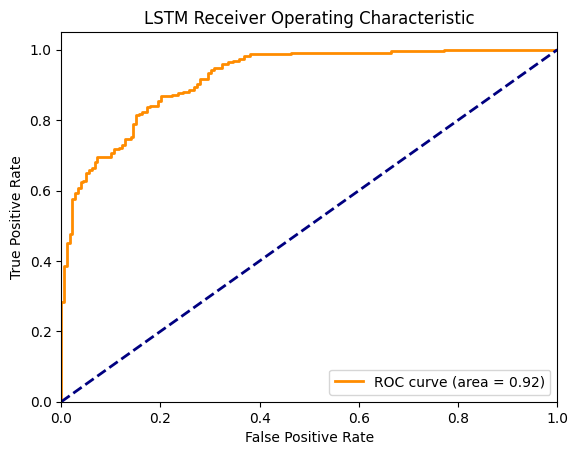

In [ ]:
# Plot LSTM ROC curve
y_pred_lstm = lstm_model.predict(X_test_lstm).ravel()
plot_roc_curve(y_test, y_pred_lstm, 'LSTM')


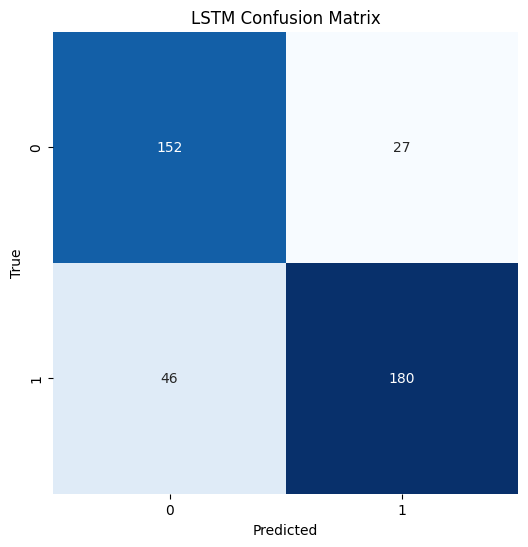

In [ ]:
# Plot LSTM confusion matrix
y_pred_lstm_class = (y_pred_lstm > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm_class, 'LSTM')


In [ ]:
# Print LSTM classification report
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm_class))

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       179
           1       0.87      0.80      0.83       226

    accuracy                           0.82       405
   macro avg       0.82      0.82      0.82       405
weighted avg       0.82      0.82      0.82       405



In [ ]:
# BiLSTM Model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.005)), input_shape=(X_train.shape[1], 1)))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Bidirectional(LSTM(50, kernel_regularizer=l2(0.005))))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dense(1, activation='sigmoid'))

bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train BiLSTM Model
bilstm_history = bilstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_split=0.2)


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5387 - loss: 2.0794 - val_accuracy: 0.5741 - val_loss: 1.7329
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5942 - loss: 1.6945 - val_accuracy: 0.5833 - val_loss: 1.4972
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5983 - loss: 1.4728 - val_accuracy: 0.5370 - val_loss: 1.3404
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5712 - loss: 1.3481 - val_accuracy: 0.6142 - val_loss: 1.2140
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6203 - loss: 1.1814 - val_accuracy: 0.5648 - val_loss: 1.1440
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6091 - loss: 1.1291 - val_accuracy: 0.6420 - val_loss: 1.0502
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5667 - loss: 1.0956 - val_accuracy: 0.6574 - val_loss: 0.9930
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6383 - loss: 0.9941 - val_accuracy: 0.

In [ ]:
# Evaluate the models
bilstm_scores = bilstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f'BiLSTM Test Accuracy: {bilstm_scores[1]}')

BiLSTM Test Accuracy: 0.8913580179214478


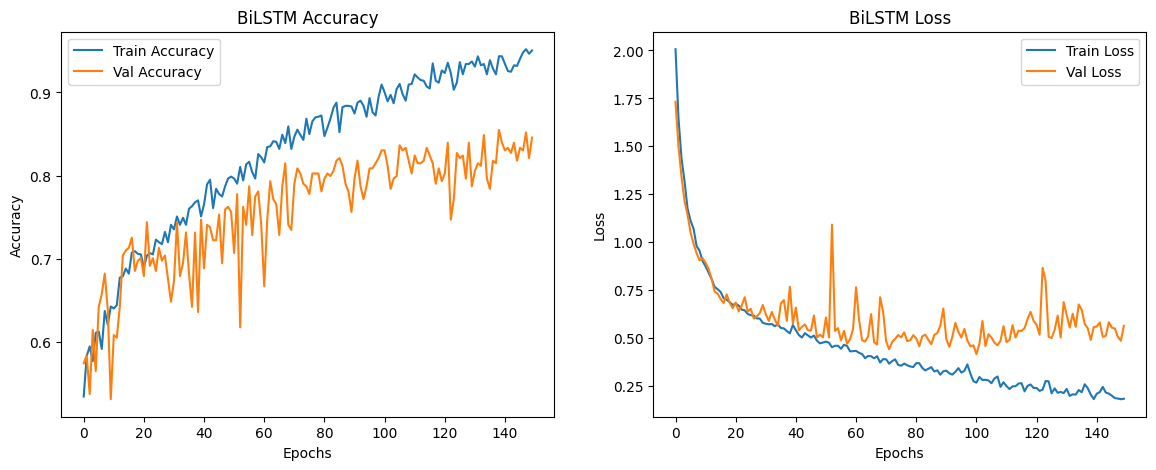

In [ ]:
# Plot BiLSTM training history
plot_training_history(bilstm_history, 'BiLSTM')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


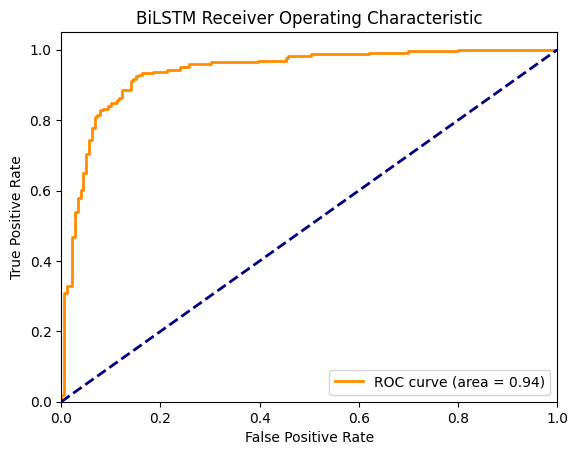

In [ ]:
# Plot BiLSTM ROC curve
y_pred_bilstm = bilstm_model.predict(X_test_lstm).ravel()
plot_roc_curve(y_test, y_pred_bilstm, 'BiLSTM')


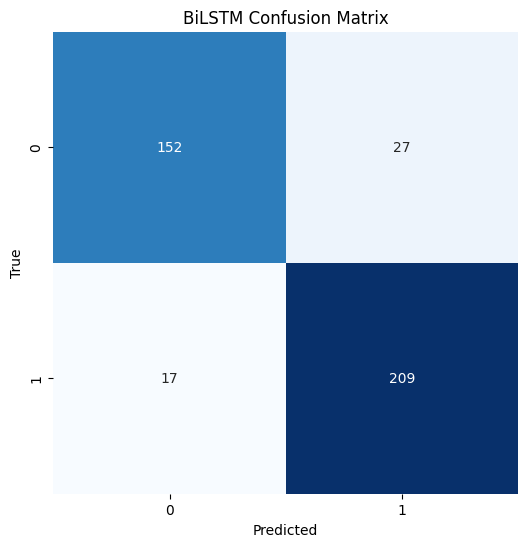

In [ ]:
# Plot BiLSTM confusion matrix
y_pred_bilstm_class = (y_pred_bilstm > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_bilstm_class, 'BiLSTM')


In [ ]:
# Print BiLSTM classification report
print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred_bilstm_class))

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       179
           1       0.89      0.92      0.90       226

    accuracy                           0.89       405
   macro avg       0.89      0.89      0.89       405
weighted avg       0.89      0.89      0.89       405



**4 class**

In [ ]:
# Load the data
label_data_path = '/kaggle/input/sr-label/data_lable.xlsx'
audio_folder_path = '/kaggle/input/speech-recognition-dataset/dataset/'

In [ ]:
# Read labels
labels_df = pd.read_excel(label_data_path)

In [ ]:
# Function to plot audio waveform
def plot_waveform(data, sr, title='Audio Waveform'):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


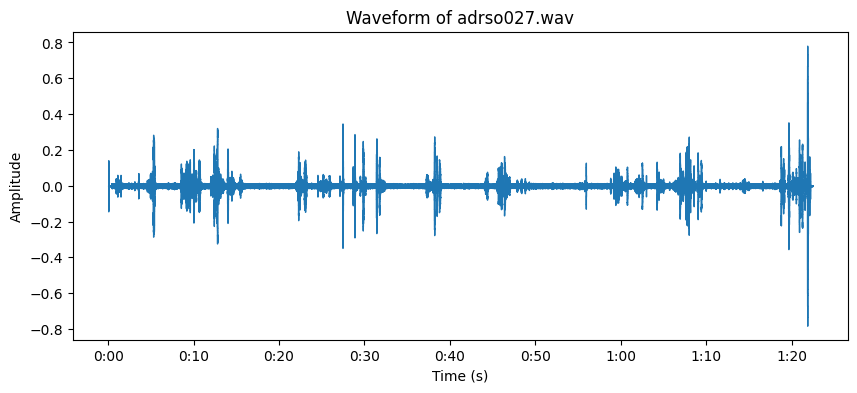

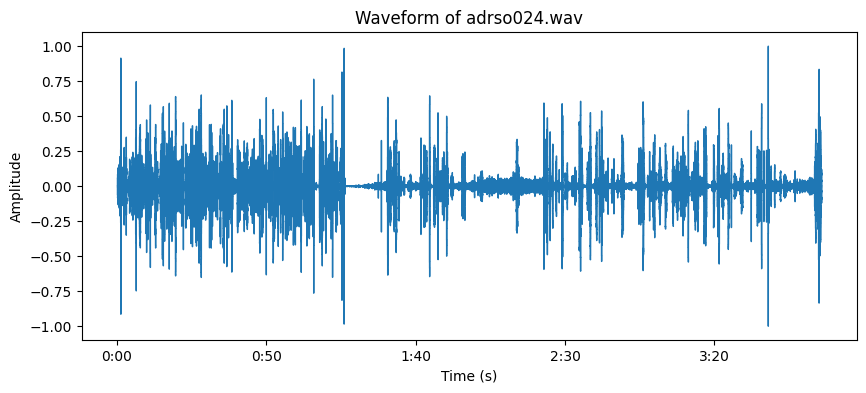

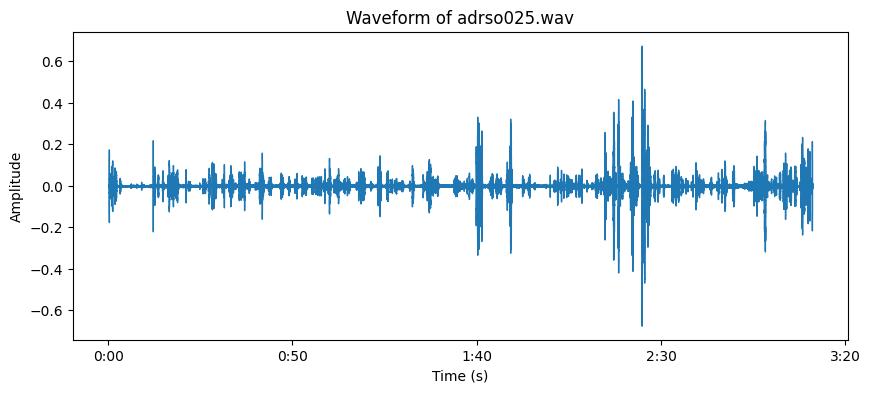

In [ ]:
# Load and plot initial audio files
for idx, row in labels_df.head(3).iterrows():  # Plot first 3 audio files
    file_path = os.path.join(audio_folder_path, row['ID'])
    data, sr = librosa.load(file_path, sr=None)
    plot_waveform(data, sr, title=f'Waveform of {row["ID"]}')

In [ ]:
# Data Augmentation Functions
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def pitch_shift(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

In [ ]:
# Load and augment the audio data
audio_data = []
audio_labels = []

def load_and_augment_audio(file_path, label):
    data, sr = librosa.load(file_path, sr=None)
    augmented_data = [
        data,
        add_noise(data),
        pitch_shift(data, sr),
        time_stretch(data, 0.9),
        time_stretch(data, 1.1)
    ]
    for aug_data in augmented_data:
        audio_data.append(aug_data)
        audio_labels.append(label)

In [ ]:
# Iterate through all files and apply augmentation
for idx, row in labels_df.iterrows():
    file_path = os.path.join(audio_folder_path, row['ID'])
    label = row['Stage class']
    load_and_augment_audio(file_path, label)

In [ ]:
# Segment the audio data into 25-second segments
def segment_audio(data, sr, segment_length=25):
    segment_samples = sr * segment_length
    segments = []
    for start in range(0, len(data), segment_samples):
        end = start + segment_samples
        if end <= len(data):
            segments.append(data[start:end])
    return segments

In [ ]:
segmented_data = []
segmented_labels = []

In [ ]:
for data, label in zip(audio_data, audio_labels):
    sr = librosa.get_samplerate(audio_folder_path + labels_df['ID'][0])
    segments = segment_audio(data, sr)
    segmented_data.extend(segments)
    segmented_labels.extend([label] * len(segments))

In [ ]:
# Function to calculate percentage of silence
def calculate_silence_percentage(segment, sr, silence_threshold=0.01):
    silent_samples = np.sum(np.abs(segment) < silence_threshold)
    silence_percentage = silent_samples / len(segment)
    return silence_percentage

In [ ]:
# Feature extraction
def extract_features(data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

In [ ]:
features = []
silence_percentages = []

In [ ]:
for segment in segmented_data:
    sr = librosa.get_samplerate(audio_folder_path + labels_df['ID'][0])
    mfccs = extract_features(segment, sr)
    silence_percentage = calculate_silence_percentage(segment, sr)
    combined_features = np.append(mfccs, silence_percentage)
    features.append(combined_features)


In [ ]:
X = np.array(features)
y = np.array(segmented_labels)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Plot some X_train features with labels
def plot_features(X, y, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].reshape(-1, 1), aspect='auto', cmap='viridis')
        plt.title(f'Label: {y[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

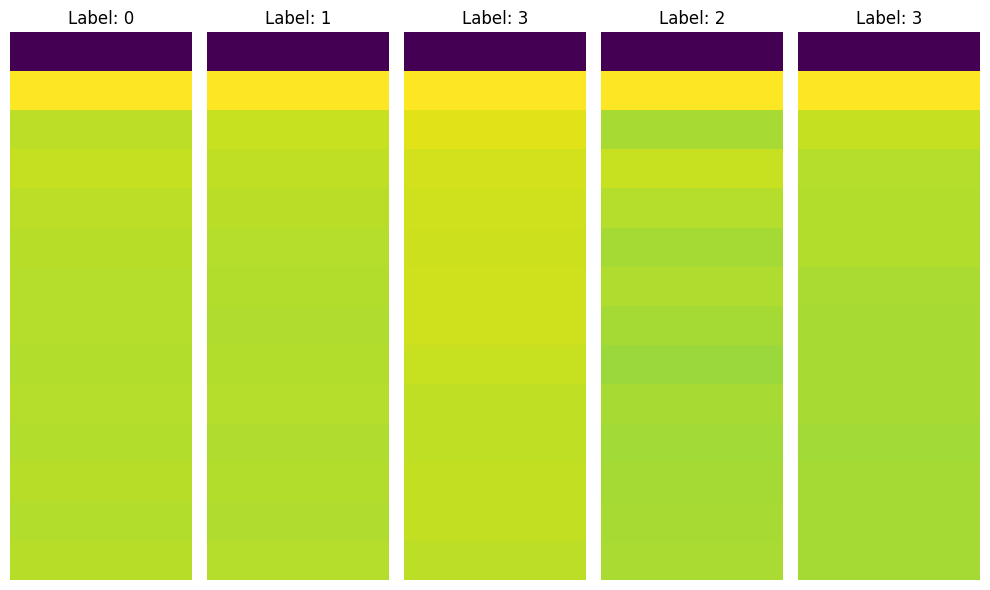

In [ ]:
# Plot first 5 training samples
plot_features(X_train, y_train)

In [ ]:
# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Building CNN model with regularization and additional dropout
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.002)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.002)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
cnn_model.add(Dropout(0.4))
# Output layer with 4 units for 4-class classification and softmax activation
cnn_model.add(Dense(4, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train CNN Model
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=150, batch_size=32, validation_split=0.2) #, callbacks=[early_stopping])

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.2855 - loss: 12.9466 - val_accuracy: 0.4784 - val_loss: 2.9289
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3219 - loss: 4.2346 - val_accuracy: 0.4630 - val_loss: 2.7172
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3344 - loss: 3.1063 - val_accuracy: 0.4660 - val_loss: 2.5912
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3881 - loss: 2.7519 - val_accuracy: 0.4753 - val_loss: 2.4787
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4123 - loss: 2.5170 - val_accuracy: 0.4784 - val_loss: 2.3507
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4149 - loss: 2.4097 - val_accuracy: 0.4753 - val_loss: 2.2241
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4533 - loss: 2.2637 - val_accuracy: 0.4815 - val_loss: 2.1715
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4262 - loss: 2.2118 - val_accuracy: 0.4815

In [ ]:
# Evaluate the models
cnn_scores = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'CNN Test Accuracy: {cnn_scores[1]}')

CNN Test Accuracy: 0.750617265701294


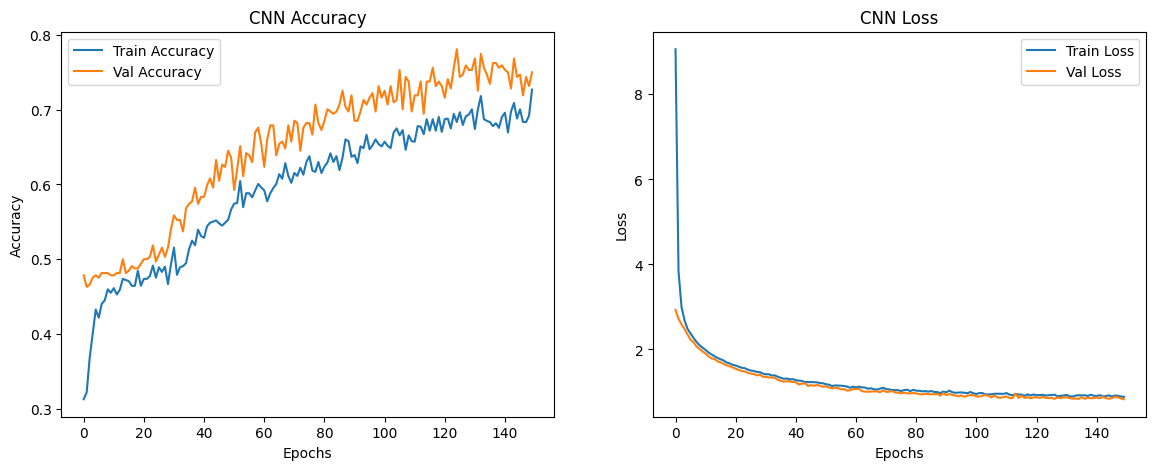

In [ ]:
# Plot LSTM training history
plot_training_history(history_cnn, 'CNN')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


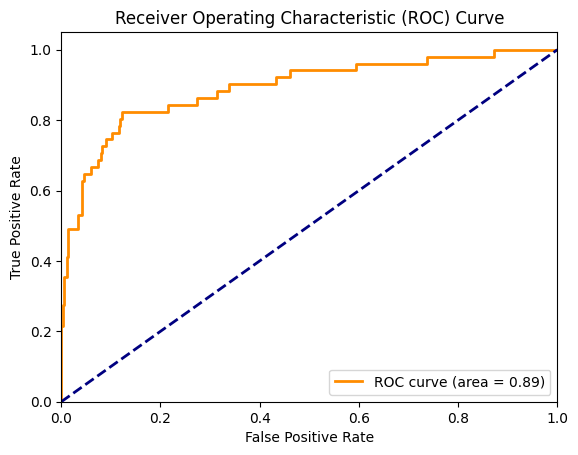

In [ ]:
# Predict probabilities for each class on the test set
y_pred_prob = cnn_model.predict(X_test_cnn)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)  # Adjust indices based on your class labels
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       179
           1       0.71      0.47      0.56        51
           2       0.81      0.58      0.67        95
           3       0.82      0.74      0.78        80

    accuracy                           0.75       405
   macro avg       0.76      0.68      0.71       405
weighted avg       0.76      0.75      0.74       405



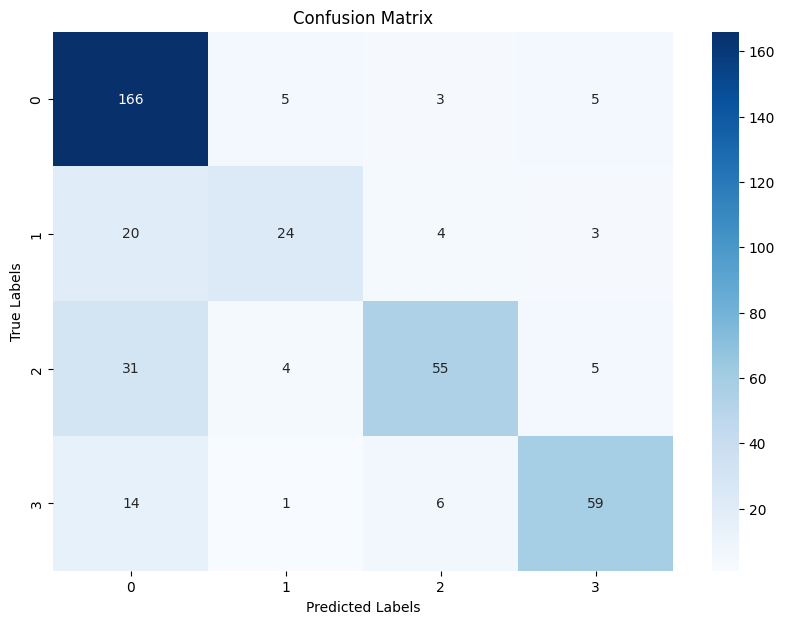

In [ ]:
# Get predicted labels and generate classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.002), input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(50, kernel_regularizer=l2(0.002)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Building LSTM model with regularization and additional layers
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(50, kernel_regularizer=l2(0.02)))
lstm_model.add(Dropout(0.2))
lstm_model.add(BatchNormalization())
# Output layer with 4 units for 4-class classification and softmax activation
lstm_model.add(Dense(4, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train LSTM Model
X_train_lstm = np.expand_dims(X_train, axis=-1)
X_test_lstm = np.expand_dims(X_test, axis=-1)
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_split=0.2)


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3183 - loss: 3.1353 - val_accuracy: 0.4660 - val_loss: 2.5023
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3529 - loss: 2.5245 - val_accuracy: 0.4753 - val_loss: 2.1351
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4279 - loss: 2.1203 - val_accuracy: 0.4877 - val_loss: 1.8764
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4398 - loss: 1.8956 - val_accuracy: 0.4846 - val_loss: 1.7038
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4555 - loss: 1.6943 - val_accuracy: 0.4784 - val_loss: 1.5865
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4424 - loss: 1.6402 - val_accuracy: 0.4784 - val_loss: 1.5104
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4707 - loss: 1.5009 - val_accuracy: 0.4691 - val_loss: 1.4050
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4947 - loss: 1.4142 - val_accuracy: 0.5216 - 

In [ ]:
# Evaluate the models
lstm_scores = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f'LSTM Test Accuracy: {lstm_scores[1]}')

LSTM Test Accuracy: 0.770370364189148


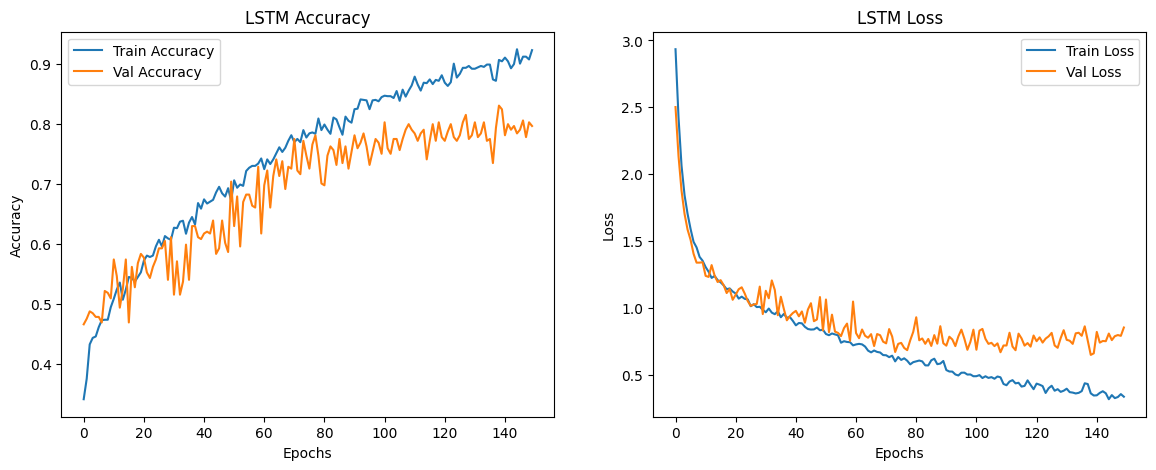

In [ ]:
# Plot LSTM training history
plot_training_history(lstm_history, 'LSTM')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


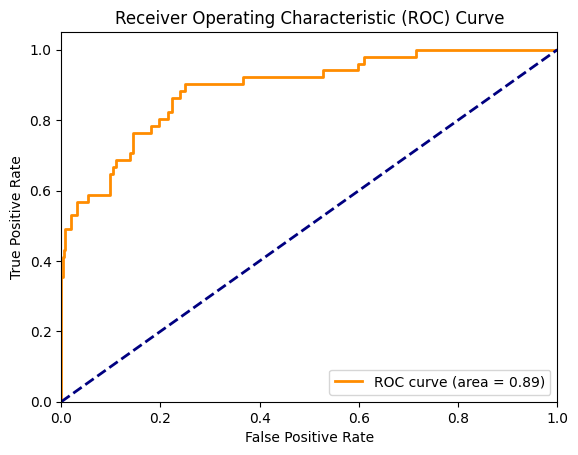

In [ ]:
# Predict probabilities for each class on the test set
y_pred_prob = lstm_model.predict(X_test_lstm)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)  # Adjust indices based on your class labels
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       179
           1       0.81      0.49      0.61        51
           2       0.70      0.74      0.72        95
           3       0.80      0.80      0.80        80

    accuracy                           0.77       405
   macro avg       0.77      0.72      0.74       405
weighted avg       0.77      0.77      0.77       405



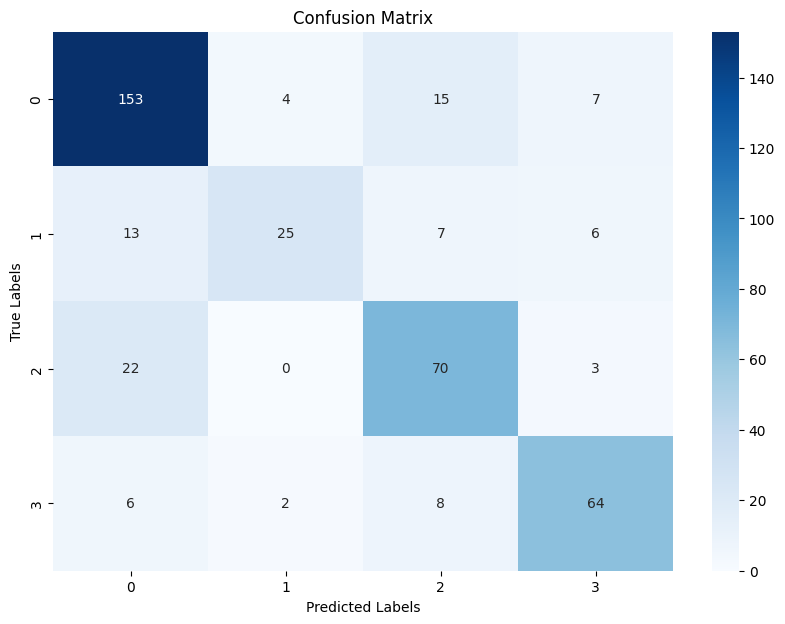

In [ ]:
# Get predicted labels and generate classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Building BiLSTM model with regularization and additional layers
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.02)), input_shape=(X_train.shape[1], 1)))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Bidirectional(LSTM(50, kernel_regularizer=l2(0.02))))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(BatchNormalization())
# Output layer with 4 units for 4-class classification and softmax activation
bilstm_model.add(Dense(4, activation='softmax'))

bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train BiLSTM Model
bilstm_history = bilstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=32, validation_split=0.2)


Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2897 - loss: 6.7354 - val_accuracy: 0.4691 - val_loss: 4.9067
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3860 - loss: 4.7606 - val_accuracy: 0.4630 - val_loss: 3.7103
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4445 - loss: 3.6495 - val_accuracy: 0.4815 - val_loss: 2.9744
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4061 - loss: 3.0258 - val_accuracy: 0.4938 - val_loss: 2.5182
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4486 - loss: 2.5519 - val_accuracy: 0.4722 - val_loss: 2.2016
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4230 - loss: 2.3045 - val_accuracy: 0.5031 - val_loss: 1.9726
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4398 - loss: 2.0447 - val_accuracy: 0.5000 - val_loss: 1.8322
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4622 - loss: 1.8738 - val_accuracy: 0.

In [ ]:
# Evaluate the models
bilstm_scores = bilstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f'BiLSTM Test Accuracy: {bilstm_scores[1]}')

BiLSTM Test Accuracy: 0.760493814945221


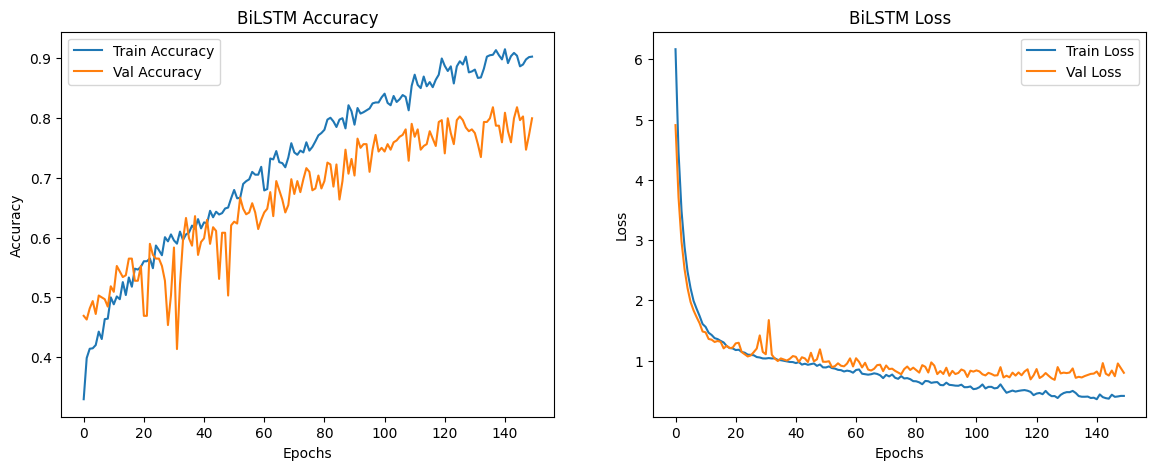

In [ ]:
# Plot BiLSTM training history
plot_training_history(bilstm_history, 'BiLSTM')


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


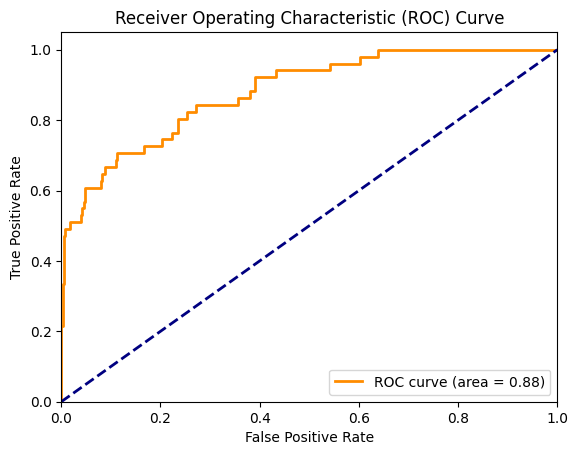

In [ ]:
# Predict probabilities for each class on the test set
y_pred_prob = bilstm_model.predict(X_test_lstm)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)  # Adjust indices based on your class labels
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       179
           1       0.84      0.51      0.63        51
           2       0.67      0.69      0.68        95
           3       0.79      0.79      0.79        80

    accuracy                           0.76       405
   macro avg       0.77      0.71      0.73       405
weighted avg       0.76      0.76      0.76       405



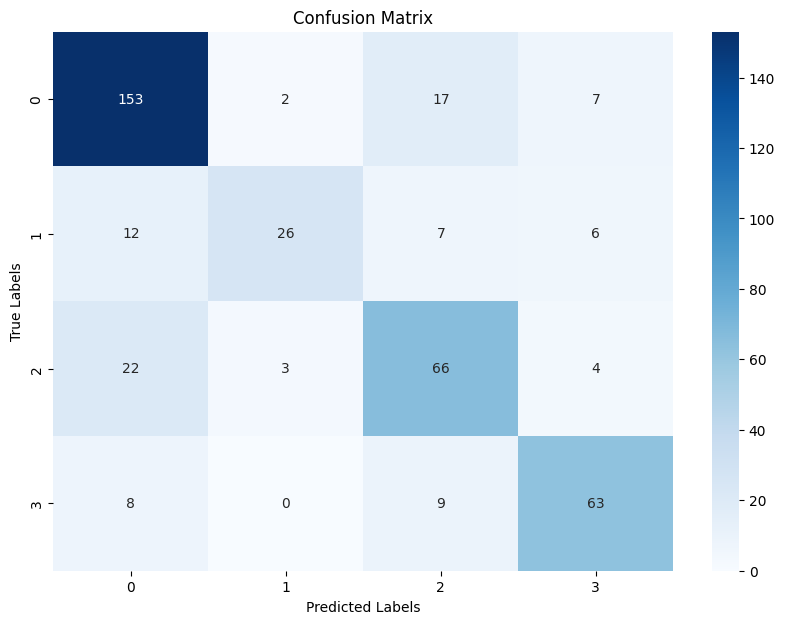

In [ ]:
# Get predicted labels and generate classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()